In [77]:
# public library imports
import pandas as pd
import os
import numpy as np
print("Current directory:", os.getcwd())
import sys
sys.path.append('.')
import torch
from collections import deque
from tqdm import tqdm
import os
import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import clear_output

# own imports  
from MDQN import ReplayBuffer, M_DQN_Agent
from Trading_Simulator import TradingEnvironment
from Residual_Generator import PCA, IPCA, PCA_old
from Signal_Extractor import FourierExtractor, CNNTransformerExtractor, CumsumExtractor
from TD3 import ReplayBuffer_TD3, TD3
from QR_DQN import DQN_Agent


%reload_ext autoreload
%autoreload 2

Current directory: /Users/quintengeerts/Desktop/master thesis/stat_arb_thesis/empirical_analysis


In [26]:
# USE THE DATASET FROM WHARTON RESEARCH DATA SERVICES for returns data
filename = 'wrds_daily_returns_permno.csv'
if os.path.exists(filename):
    price_df = pd.read_csv(filename)
    price_df.set_index('date', inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

price_df = price_df.loc[:dt.datetime(2021,12,31)]
price_df = price_df.replace(['C','B'],np.nan).astype(float)
price_df = price_df[(price_df.index >= dt.datetime(1996,1,1)) & (price_df.index < dt.datetime(2023,1,1))].dropna(axis=0, thresh=300)
#price_df = price_df.dropna(axis=1,how='all')

/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_12234/1909723732.py:4: DtypeWarning: Columns (21,41,83,93,98,103,118,120,155,161,171,187,193,196,197,204,211,236,243,248,253,266,274,278,288,292,297,312,317,322,330,337,346,348,372,392,399,409,422,434,439,449,464,468,470,474,487,489,490,494,495,503,506,524,539,549,550,581,583,611,615,616,618,630,634,635,662,710,725,726,728,729,732,742,749,751,760,769,782,785,794,817,818,827,830,834,838,880,881,923,937,960,973,1001,1002,1007,1022,1094,1104,1111,1112,1126,1145,1151,1155,1171,1172,1177,1178,1179) have mixed types. Specify dtype option on import or set low_memory=False.
  price_df = pd.read_csv(filename)


In [109]:
test = price_df.copy()

In [8]:
# # USE THE DATASET FROM WHARTON RESEARCH DATA SERVICES for returns data
# filename = 'wrds_daily_returns.csv'
# if os.path.exists(filename):
#     price_df = pd.read_csv(filename)
#     price_df.set_index('date', inplace=True)
#     price_df.index = pd.to_datetime(price_df.index)

# price_df = price_df.loc[:dt.datetime(2021,12,31)]
# price_df = price_df.replace(['C','B'],np.nan).astype(float)
# price_df = price_df[(price_df.index >= dt.datetime(1996,1,1)) & (price_df.index < dt.datetime(2023,1,1))].dropna(axis=0, thresh=300)
# price_df = price_df.dropna(axis=1,how='all')

# USE THE DATASET FROM WHARTON RESEARCH DATA SERVICES
filename = 'wrds_daily_returns.csv'
if os.path.exists(filename):
    price_df = pd.read_csv(filename)
    price_df.set_index('date', inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

price_df = price_df.loc[:dt.datetime(2021,12,31)]
price_df = price_df.replace(['C','B'],np.nan).astype(float)

/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_12234/959128431.py:16: DtypeWarning: Columns (21,41,83,93,98,103,118,155,161,171,196,197,236,243,248,253,266,274,278,288,312,330,346,372,409,422,434,439,449,464,470,487,489,490,494,495,506,524,539,549,550,581,583,611,615,616,618,630,634,635,662,710,725,726,728,729,732,742,751,760,769,782,785,794,817,818,834,838,880,881,923,937,960,1001,1002,1007,1022,1094,1112,1126,1151,1155,1171,1172,1177,1178,1179) have mixed types. Specify dtype option on import or set low_memory=False.
  price_df = pd.read_csv(filename)


In [17]:
# USE THE DATASET FROM WHARTON RESEARCH DATA SERVICES for fundamental data
panel = pd.read_csv('monthly_IPCA_panel.csv')
panel.drop(columns=['Unnamed: 0'], inplace=True)
panel.date = pd.to_datetime(panel.date)
panel = panel.drop(['AC', 'DPI2A','OA','OL','OP','SGA2S'],axis=1)
panel = panel.dropna(axis=0)

In [2]:
# USE THE DATASET FROM eod.com
filename = 'price_df.csv'
if os.path.exists(filename):
    price_df = pd.read_csv(filename)
    price_df = price_df.rename(columns={'Unnamed: 0':'date'})
    price_df.set_index('date', inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

price_df = price_df.loc[dt.datetime(1998,1,1):].dropna(axis=0, thresh=300)

In [6]:
action_to_portfolio = {0:-1, 1:0, 2: 1}

### 1) Backwards test with fourier signal extractor -- MDQN

 Episode: 46 -- Annualized Return: -10.92% -- Annualized Volatility: 3.14% -- Annualized Sharpe: -3.47
 Episode: 46 -- Total ann. Return: -6.86% -- Total ann. Volatility: 2.93% -- Total ann. Sharpe: -2.34
Episode 47	Frame 1175 	Average Score: -0.01

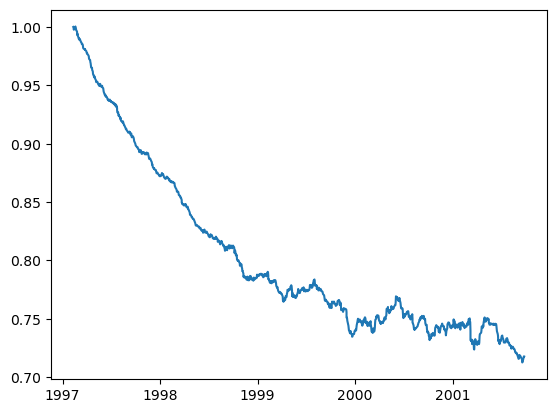

KeyboardInterrupt: 

In [71]:
# PARAMETERS
seed = 100  #np.random.randint(0,100000)

frames      = 6200
BUFFER_SIZE = 1000000
BATCH_SIZE  = 64
GAMMA       = 0.99
TAU         = 1e-2
eps_frames  = 500
min_eps     = 0.0
LR          = 1e-3
UPDATE_EVERY= 5
n_step      = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)

action_size       = 3
state_size        = [31]

agent = M_DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        layer_size=64,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed)

##########################

MINIMUM_BUFFER  = 5000      # minimum amount of experiences before the DRL agent starts learning
EPISODE_LENGTH  = 25        # episode length, only used for telling when to show the performance
LOOKBACK_WINDOW = 252       # lookback window used for the PCA estimation
LOADING_WINDOW  = 60        # last 30 values are used to create the loadings for the factor model
FACTORS         = 5         # the amount of factors used in the factor model
SIGNAL_WINDOW   = 30        # the length of the window used for extracting the signal
TRANS_COST      = 0.0005    # transaction cost for changes in the portfolio
SHORT_COST      = 0.0001    # cost of keeping a short position open
WARMUP_TIME     = 0         # time needed to run the factor models before starting the strategy
RETRAIN_EVERY   = 250       # time before the feature extractor is retrained on new data
USE_ALLOC       = True

residual_generator = PCA(price_data=price_df,
                         amount_of_factors = FACTORS,
                         loadings_window_size=LOADING_WINDOW,
                         lookback_window_size=LOOKBACK_WINDOW)

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=residual_generator,
                        episode_length=EPISODE_LENGTH,
                        lookback_window=LOOKBACK_WINDOW,
                        loading_window=LOADING_WINDOW,
                        signal_window=SIGNAL_WINDOW,
                        transaction_costs=TRANS_COST,
                        short_cost=SHORT_COST,
                        add_alloc=USE_ALLOC)

signal_extractor = FourierExtractor(signal_window=SIGNAL_WINDOW,
                                    add_alloc=USE_ALLOC)

buffer           = ReplayBuffer(buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE,
                                device=device,
                                seed=seed,
                                gamma=GAMMA,
                                n_step=1)

state, _ = env.warm_up(warmup_time=WARMUP_TIME)
signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date])
features = state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray
features = signal_extractor.extract(features)

# INITIALISING SOME VARIABLES
score = 1
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

#training loop
for frame in range(1, frames+1):

    action = agent.act_para(features, eps)
    portfolio_allocations = np.vectorize(action_to_portfolio.get)(action) #actions need to be turned into allocations
    next_state, reward, done, info = env.step(portfolio_allocations.T)
    
    # ADD TO BUFFER 
    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], state[ticker].values, True)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], next_state[ticker].values, False)

        # DEEP REINFORCEMENT LEARNING UPDATE
        if len(buffer) > MINIMUM_BUFFER and idx % UPDATE_EVERY == 0:
            experiences = buffer.sample()
            # extract the features using the current feature extractor
            states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer = experiences
            features_buffer      = torch.FloatTensor(signal_extractor.extract(states_buffer))
            next_features_buffer = torch.FloatTensor(signal_extractor.extract(next_states_buffer))
            experiences          = (features_buffer, actions_buffer, rewards_buffer, next_features_buffer, dones_buffer)
            # perform a learning stepre
            agent.learn(experiences)

    # FEATURE EXTRACTOR RETRAINING
    if frame % RETRAIN_EVERY == 0:
        signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date]) 
    
    state     = next_state
    features  = next_state[env.tradeable_tickers].values.T
    features = signal_extractor.extract(features)

    score *= (env.p_l + 1)
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = 0 # max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)
    
    if frame % EPISODE_LENGTH == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1 

In [165]:
test = pd.read_csv('res_rets.csv')
test.set_index(test.date, inplace=True)
test.drop('date', inplace=True, axis=1)

In [177]:
test.astype(float).min().min()

-0.8852888585901604

In [164]:
env.res_rets

,NUE,HLT_x,ABT,CEN,DH,COO,SOTR,JDSU,URBN,ANF,...,ANDW,FOXA,FOX_y,PPL,TXU,MEL,GNT,DOW_y,TEL,HSP
date,,,,,,,,,,,,,,,,,,,,,
1996-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


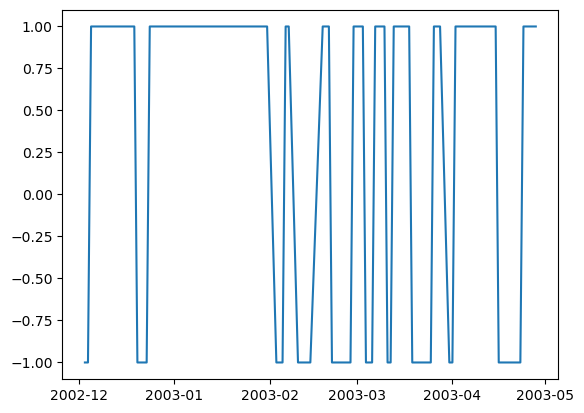

In [68]:
plt.plot(env.res_alloc.loc[env.res_rets['34817'].dropna().index,'34817'].tail(100))

In [56]:
price_df

,34817,14338,20482,38914,49154,65541,71686,79879,79881,83976,...,14323,18420,18421,22517,24563,59379,67571,18428,92157,90110
date,,,,,,,,,,,,,,,,,,,,,
1996-01-02,-0.006565,NaN,0.003003,-0.003030,0.021667,NaN,NaN,NaN,NaN,NaN,...,0.045752,NaN,NaN,0.000000,0.003049,-0.004651,NaN,NaN,NaN,NaN
1996-01-03,0.030837,NaN,0.002994,-0.006079,0.011419,NaN,NaN,NaN,NaN,NaN,...,-0.006250,NaN,NaN,0.000000,0.018237,0.009346,NaN,NaN,NaN,NaN
1996-01-04,-0.036325,NaN,0.014925,-0.021407,-0.009677,NaN,NaN,NaN,NaN,NaN,...,-0.044025,NaN,NaN,0.005000,-0.005970,-0.039352,NaN,NaN,NaN,NaN
1996-01-05,-0.024390,NaN,-0.020588,-0.006250,-0.011401,NaN,NaN,NaN,NaN,NaN,...,0.032895,NaN,NaN,0.009950,0.003003,0.000000,NaN,NaN,NaN,NaN
1996-01-08,0.000000,NaN,0.018018,0.006289,0.016474,NaN,NaN,NaN,NaN,NaN,...,0.006369,NaN,NaN,-0.004926,0.000000,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.020560,0.003749,0.016528,NaN,0.013981,0.021449,NaN,NaN,NaN,NaN,...,NaN,0.001073,0.003187,0.003739,NaN,NaN,NaN,0.013239,0.027390,NaN
2021-12-28,-0.018860,-0.001739,-0.006998,NaN,0.003614,0.000905,NaN,NaN,NaN,NaN,...,NaN,0.004555,0.004333,0.008127,NaN,NaN,NaN,0.013603,-0.001229,NaN
2021-12-29,0.003844,0.002258,0.005126,NaN,0.013383,0.000642,NaN,NaN,NaN,NaN,...,NaN,-0.010670,-0.011217,0.000672,NaN,NaN,NaN,0.007593,-0.000984,NaN


In [138]:
price_df['34817'].describe()

KeyError: '34817'

In [121]:
env.res_rets[['NUE']]

,NUE
date,
1996-01-02,NaN
1996-01-03,NaN
1996-01-04,NaN
1996-01-05,NaN
1996-01-08,NaN
...,...
2021-12-27,NaN
2021-12-28,NaN
2021-12-29,NaN


In [141]:
env.res_rets[['NUE']].dropna().min()

NUE   -0.086631
dtype: object

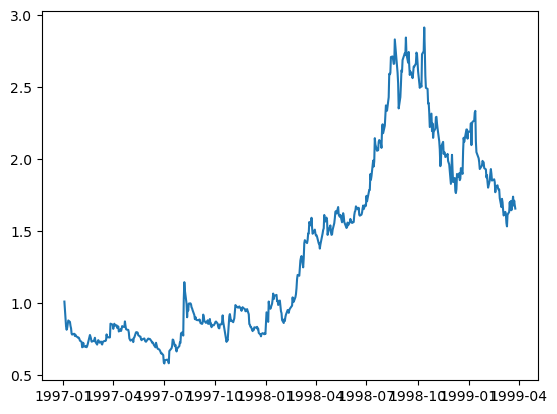

In [192]:
plt.plot((env.res_rets[['AAPL']].dropna()+1).cumprod())

In [51]:
env.res_rets[['34817']].min()

34817   -10.106375
dtype: object

In [23]:
env.total_pl.to_csv('results_pl.csv')
env.res_rets.to_csv('res_rets.csv')
env.res_alloc.to_csv('res_alloc.csv')

/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_12234/737986909.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


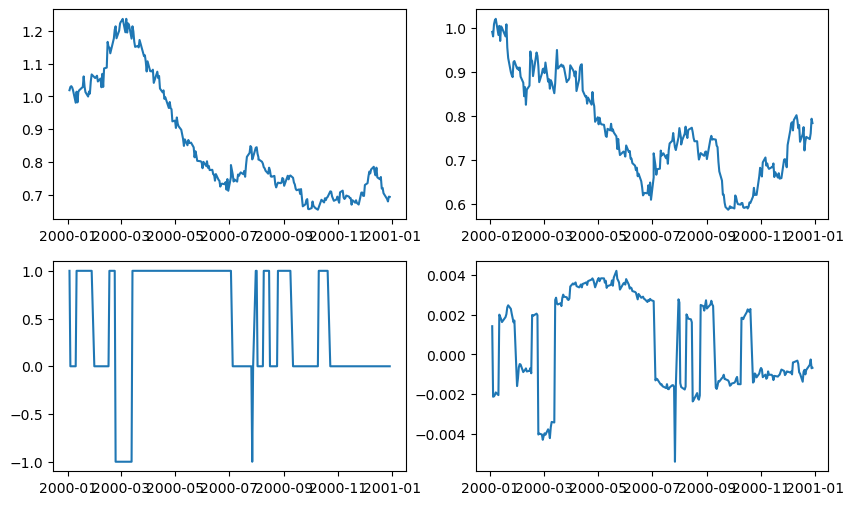

In [73]:
stock = '34817'
begin = dt.datetime(2000,1,1)
end   = dt.datetime(2001,1,1)
residual_test = (env.res_rets.loc[begin:end,stock]+1).cumprod()
alloc_test    = env.res_alloc.loc[begin:end,stock]
fig, ax  = plt.subplots(2,2,figsize=(10,6))
ax[0,0].plot(residual_test)
ax[1,0].plot(alloc_test)

alloc_test    = env.asset_alloc.loc[begin:end,stock]
residual_test = (env.data.loc[begin:end,stock]+1).cumprod()
ax[0,1].plot(residual_test)
ax[1,1].plot(alloc_test)
fig.show()

### 2) Backward test with CNN+Transformer as signal extractor -- MDQN

 Episode: 243 -- Annualized Return: 6.88% -- Annualized Volatility: 1.83% -- Annualized Sharpe: 3.77
 Episode: 243 -- Total ann. Return: 4.47% -- Total ann. Volatility: 2.29% -- Total ann. Sharpe: 1.95


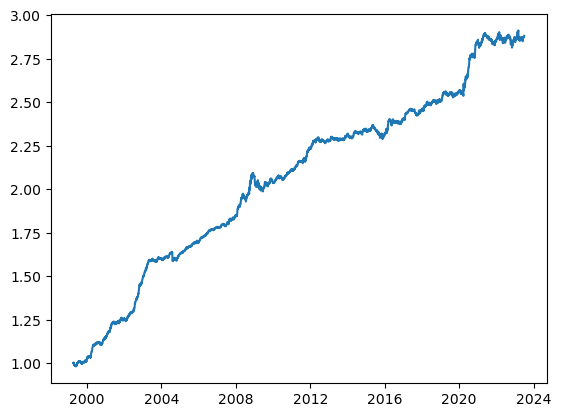

In [30]:
# PARAMETERS
seed = 100  #np.random.randint(0,100000)

frames      = 6200
BUFFER_SIZE = 1000000
BATCH_SIZE  = 64
GAMMA       = 0.99
TAU         = 1e-2
eps_frames  = 500
min_eps     = 0.025
LR          = 1e-3
UPDATE_EVERY= 5
n_step      = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)

action_size       = 3
state_size        = [8]

agent = M_DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        layer_size=8,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed,
                        use_transf=False)

##########################

MINIMUM_BUFFER  = 5000      # minimum amount of experiences before the DRL agent starts learning
EPISODE_LENGTH  = 25        # episode length, only used for telling when to show the performance
LOOKBACK_WINDOW = 252       # lookback window used for the PCA estimation
LOADING_WINDOW  = 60        # last 30 values are used to create the loadings for the factor model
FACTORS         = 5         # the amount of factors used in the factor model
SIGNAL_WINDOW   = 60        # the length of the window used for extracting the signal
TRANS_COST      = 0.0       # transaction cost for changes in the portfolio
SHORT_COST      = 0.0       # cost of keeping a short position open

WARMUP_TIME     = 100       # time needed to run the factor models before starting the strategy
RETRAIN_EVERY   = 5         # time before the feature extractor is retrained on new data
BATCH_SIZE_EXTR = 5

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=PCA,
                        episode_length=EPISODE_LENGTH,
                        lookback_window=LOOKBACK_WINDOW,
                        loading_window=LOADING_WINDOW,
                        signal_window=SIGNAL_WINDOW,
                        factors=FACTORS,
                        transaction_costs=TRANS_COST,
                        short_cost=SHORT_COST)

#signal_extractor = CumsumExtractor(signal_window=SIGNAL_WINDOW)
signal_extractor = CNNTransformerExtractor(signal_window=SIGNAL_WINDOW)


buffer           = ReplayBuffer(buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE,
                                device=device,
                                seed=seed,
                                gamma=GAMMA,
                                n_step=1)

state, _ = env.warm_up(warmup_time=WARMUP_TIME)
signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date])
features = state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray
features = signal_extractor.extract(features)

# INITIALISING SOME VARIABLES
score = 1
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

#training loop
for frame in range(1, frames+1-WARMUP_TIME):

    action = agent.act_para(features, eps)
    portfolio_allocations = np.vectorize(action_to_portfolio.get)(action) #actions need to be turned into allocations
    next_state, reward, done, info = env.step(portfolio_allocations.T)
    
    # ADD TO BUFFER 
    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], state[ticker].values, True)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], next_state[ticker].values, False)

        # DEEP REINFORCEMENT LEARNING UPDATE
        if len(buffer) > MINIMUM_BUFFER and idx % UPDATE_EVERY == 0:
            experiences = buffer.sample()
            # extract the features using the current feature extractor
            states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer = experiences
            features_buffer      = torch.FloatTensor(signal_extractor.extract(states_buffer))
            next_features_buffer = torch.FloatTensor(signal_extractor.extract(next_states_buffer))
            experiences          = (features_buffer, actions_buffer, rewards_buffer, next_features_buffer, dones_buffer)
            # perform a learning step
            agent.learn(experiences)

    # FEATURE EXTRACTOR RETRAINING
    if frame % RETRAIN_EVERY == 0:
        signal_extractor.re_train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date],
                                  sample_size = BATCH_SIZE_EXTR) 
    
    state     = next_state
    features  = next_state[env.tradeable_tickers].values.T
    features  = signal_extractor.extract(features)

    score *= (env.p_l + 1)
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)
    
    if frame % EPISODE_LENGTH == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1 

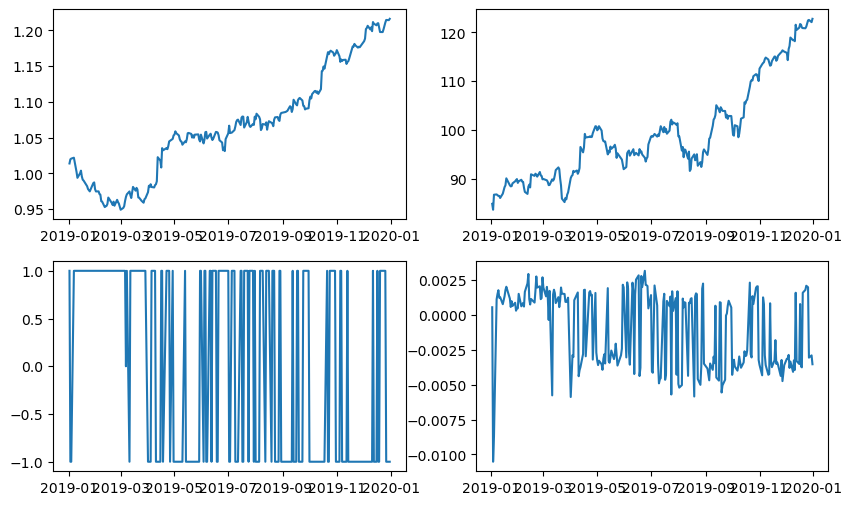

In [33]:
stock = 'JPM'
begin = dt.datetime(2019,1,1)
end   = dt.datetime(2020,1,1)
residual_test = (env.res_rets.loc[begin:end,stock]+1).cumprod()
alloc_test    = env.res_alloc.loc[begin:end,stock]
fig, ax  = plt.subplots(2,2,figsize=(10,6))
ax[0,0].plot(residual_test)
ax[1,0].plot(alloc_test)

alloc_test    = env.asset_alloc.loc[begin:end,stock]
residual_test = (env.data.loc[begin:end,stock])
ax[0,1].plot(residual_test)
ax[1,1].plot(alloc_test)


 Episode: 19 -- Annualized Return: -30.1% -- Annualized Volatility: 20.79% -- Annualized Sharpe: -1.45
 Episode: 19 -- Total ann. Return: -2.41% -- Total ann. Volatility: 10.07% -- Total ann. Sharpe: -0.24


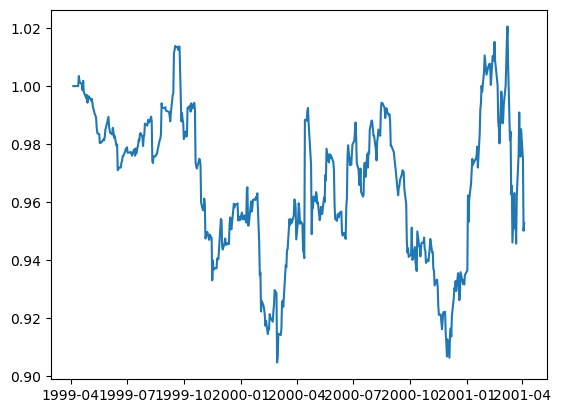

KeyboardInterrupt: 

In [79]:
# PARAMETERS
seed = 100  #np.random.randint(0,100000)

frames      = 6200
BUFFER_SIZE = 1000000
BATCH_SIZE  = 64
GAMMA       = 0.99
TAU         = 1e-2
eps_frames  = 500
min_eps     = 0.025
LR          = 1e-3
UPDATE_EVERY= 5
n_step      = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)

action_size       = 3
state_size        = [8]

agent = M_DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        layer_size=16,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed,
                        use_transf=False)

##########################

MINIMUM_BUFFER  = 5000      # minimum amount of experiences before the DRL agent starts learning
EPISODE_LENGTH  = 25        # episode length, only used for telling when to show the performance
LOOKBACK_WINDOW = 252       # lookback window used for the PCA estimation
LOADING_WINDOW  = 60        # last 30 values are used to create the loadings for the factor model
FACTORS         = 0         # the amount of factors used in the factor model
SIGNAL_WINDOW   = 60        # the length of the window used for extracting the signal
TRANS_COST      = 0.0       # transaction cost for changes in the portfolio
SHORT_COST      = 0.0       # cost of keeping a short position open

WARMUP_TIME     = 100       # time needed to run the factor models before starting the strategy
RETRAIN_EVERY   = 5         # time before the feature extractor is retrained on new data
BATCH_SIZE_EXTR = 5

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=PCA,
                        episode_length=EPISODE_LENGTH,
                        lookback_window=LOOKBACK_WINDOW,
                        loading_window=LOADING_WINDOW,
                        signal_window=SIGNAL_WINDOW,
                        factors=FACTORS,
                        transaction_costs=TRANS_COST,
                        short_cost=SHORT_COST,
                        rebalance_every=10)

#signal_extractor = CumsumExtractor(signal_window=SIGNAL_WINDOW)
signal_extractor = CNNTransformerExtractor(signal_window=SIGNAL_WINDOW)


buffer           = ReplayBuffer(buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE,
                                device=device,
                                seed=seed,
                                gamma=GAMMA,
                                n_step=1,
                                cont_action_space=False)

state, _ = env.warm_up(warmup_time=WARMUP_TIME)
signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date])
features = state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray
features = signal_extractor.extract(features)

# INITIALISING SOME VARIABLES
score = 1
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

#training loop
for frame in range(1, frames+1-WARMUP_TIME):

    action = agent.act_para(features, eps)
    portfolio_allocations = np.vectorize(action_to_portfolio.get)(action) #actions need to be turned into allocations
    next_state, reward, done, info = env.step(portfolio_allocations.T)
    
    # ADD TO BUFFER 
    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], state[ticker].values, True)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], next_state[ticker].values, False)

        # DEEP REINFORCEMENT LEARNING UPDATE
        if len(buffer) > MINIMUM_BUFFER and idx % UPDATE_EVERY == 0:
            experiences = buffer.sample()
            # extract the features using the current feature extractor
            states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer = experiences
            features_buffer      = torch.FloatTensor(signal_extractor.extract(states_buffer))
            next_features_buffer = torch.FloatTensor(signal_extractor.extract(next_states_buffer))
            experiences          = (features_buffer, actions_buffer, rewards_buffer, next_features_buffer, dones_buffer)
            # perform a learning step
            agent.learn(experiences)

    # FEATURE EXTRACTOR RETRAINING
    if frame % RETRAIN_EVERY == 0:
        signal_extractor.re_train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date],
                                  sample_size = BATCH_SIZE_EXTR) 
    
    state     = next_state
    features  = next_state[env.tradeable_tickers].values.T
    features  = signal_extractor.extract(features)

    score *= (env.p_l + 1)
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)
    
    if frame % EPISODE_LENGTH == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1 

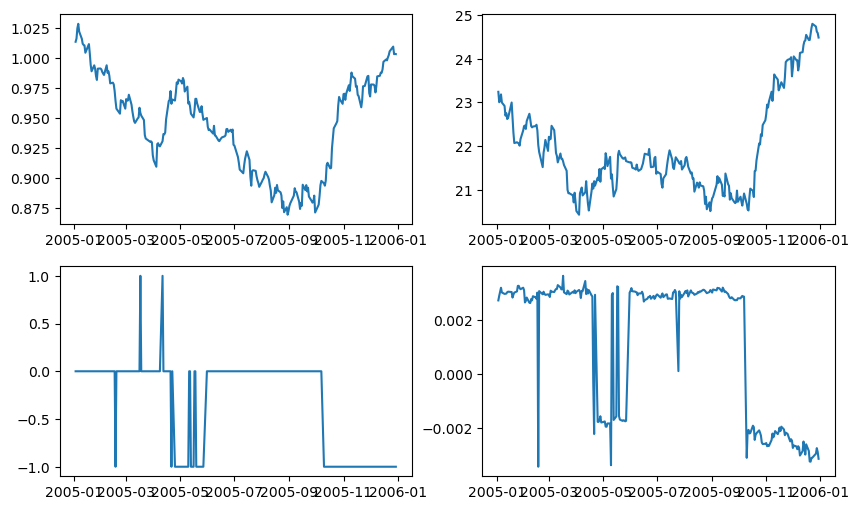

In [42]:
stock = 'JPM'
begin = dt.datetime(2005,1,1)
end   = dt.datetime(2006,1,1)
residual_test = (env.res_rets.loc[begin:end,stock]+1).cumprod()
alloc_test    = env.res_alloc.loc[begin:end,stock]
fig, ax  = plt.subplots(2,2,figsize=(10,6))
ax[0,0].plot(residual_test)
ax[1,0].plot(alloc_test)

alloc_test    = env.asset_alloc.loc[begin:end,stock]
residual_test = (env.data.loc[begin:end,stock])
ax[0,1].plot(residual_test)
ax[1,1].plot(alloc_test)

### 3) Backward test with CNN+Transformer as signal extractor -- TD3

 Episode: 24 -- Annualized Return: -3.2% -- Annualized Volatility: 4.09% -- Annualized Sharpe: -0.78
 Episode: 24 -- Total ann. Return: -2.93% -- Total ann. Volatility: 1.85% -- Total ann. Sharpe: -1.59


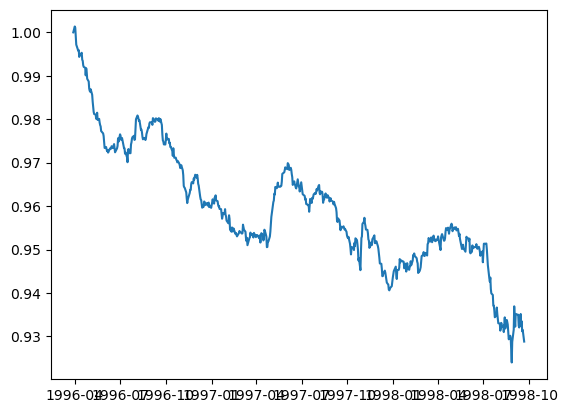

KeyboardInterrupt: 

In [10]:
# PARAMETERS
seed = 100  #np.random.randint(0,100000)
frames = 6200
alpha = 0.99 # Discount factor
tau  = 0.005 # Target network update rate

HIDDEN_DIM      = 16 #[8,8,4,4] #16
BUFFER_SIZE     = 1000000
UPDATE_EVERY    = 5
POLICY_NOISE    =  0.2 # Noise added to target policy during critic update
MAX_ACTION      = 1
POLICY_FREQ     = 2 # Frequency of delayed policy updates
EXPL_NOISE      = 0.1 # Std of Gaussian exploration noise
START_TIMESTEPS = 50  #25e3 # Time steps initial random policy is used
NOISE_CLIP      = 0.5 # Range to clip target policy noise
BATCH_SIZE      = 64  # Batch size for both actor and critic
EVAL_FREQ       = 5e3  # How often (time steps) we evaluate

state_dim = 9 # env.observation_space.shape[0]
action_dim = 1
max_action = 1
USE_ALLOC       = True


kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": alpha,
    "tau": tau,
    'hidden_dimension': HIDDEN_DIM
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)

# Initialize policy
kwargs["policy_noise"] = POLICY_NOISE * MAX_ACTION
kwargs["noise_clip"] = NOISE_CLIP * MAX_ACTION
kwargs["policy_freq"] = POLICY_FREQ
kwargs["use_alloc"]    = False #USE_ALLOC

policy = TD3(**kwargs)

##########################

MINIMUM_BUFFER  = 5000      # minimum amount of experiences before the DRL agent starts learning
EPISODE_LENGTH  = 25        # episode length, only used for telling when to show the performance
LOOKBACK_WINDOW = 252       # lookback window used for the PCA estimation
LOADING_WINDOW  = 60        # last 30 values are used to create the loadings for the factor model
FACTORS         = 5         # the amount of factors used in the factor model
SIGNAL_WINDOW   = 60        # the length of the window used for extracting the signal
TRANS_COST      = 0.0005       # transaction cost for changes in the portfolio
SHORT_COST      = 0.0001       # cost of keeping a short position open

WARMUP_TIME     = 100       # time needed to run the factor models before starting the strategy
RETRAIN_EVERY   = 5         # time before the feature extractor is retrained on new data
BATCH_SIZE_EXTR = 5

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=PCA,
                        episode_length=EPISODE_LENGTH,
                        lookback_window=LOOKBACK_WINDOW,
                        loading_window=LOADING_WINDOW,
                        signal_window=SIGNAL_WINDOW,
                        factors=FACTORS,
                        transaction_costs=TRANS_COST,
                        short_cost=SHORT_COST,
                        rebalance_every=1,
                        add_alloc=USE_ALLOC)

buffer           = ReplayBuffer(buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE,
                                device=device,
                                seed=seed,
                                gamma=alpha,
                                n_step=1,
                                cont_action_space=True)

#signal_extractor = CumsumExtractor(signal_window=SIGNAL_WINDOW)
signal_extractor = CNNTransformerExtractor(add_alloc=USE_ALLOC, signal_window=SIGNAL_WINDOW)

state, _ = env.warm_up(warmup_time=WARMUP_TIME)
signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date])
features = state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray
features = signal_extractor.extract(features)

# INITIALISING SOME VARIABLES
score = 1
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

#training loop
for frame in range(1, frames+1-WARMUP_TIME):
    # Select action randomly or according to policy
    if frame < START_TIMESTEPS:
        action = np.random.uniform(-1,1,(sum(env.tradeables),1))
    else:
        action = (
            policy.select_multiple_action(features)
            + np.random.normal(0, MAX_ACTION * EXPL_NOISE, size=(sum(env.tradeables),1))
        ).clip(-max_action, max_action)
    
    next_state, reward, done, info = env.step(action)
    
    # ADD TO BUFFER 
    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            buffer.add(state[ticker].values, action[idx,0], reward[ticker].values[0], state[ticker].values, False)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            buffer.add(state[ticker].values, action[idx,0], reward[ticker].values[0], next_state[ticker].values, True)

        # DEEP REINFORCEMENT LEARNING UPDATE
        if len(buffer) > MINIMUM_BUFFER and idx % UPDATE_EVERY == 0:
            experiences = buffer.sample()
            # extract the features using the current feature extractor
            states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer = experiences
            features_buffer      = torch.FloatTensor(signal_extractor.extract(states_buffer))
            next_features_buffer = torch.FloatTensor(signal_extractor.extract(next_states_buffer))
            experiences          = (features_buffer, actions_buffer, rewards_buffer, next_features_buffer, dones_buffer)
            # perform a learning step
            policy.train(experiences)

    # FEATURE EXTRACTOR RETRAINING
    if frame % RETRAIN_EVERY == 0:
        signal_extractor.re_train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date],
                                  sample_size = BATCH_SIZE_EXTR) 
    
    state     = next_state
    features  = next_state[env.tradeable_tickers].values.T
    features  = signal_extractor.extract(features)

    score *= (env.p_l + 1)
    
    if frame % EPISODE_LENGTH == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1 

### 3) Backward test with Fourier transform as signal extractor -- TD3

 Episode: 83 -- Annualized Return: 0.23% -- Annualized Volatility: 2.62% -- Annualized Sharpe: 0.09
 Episode: 83 -- Total ann. Return: -2.21% -- Total ann. Volatility: 3.7% -- Total ann. Sharpe: -0.6


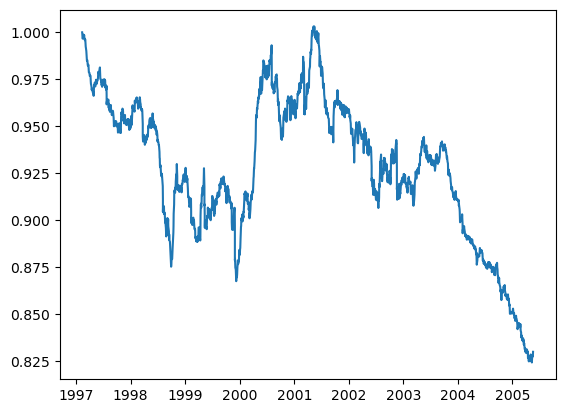

KeyboardInterrupt: 

In [76]:
# PARAMETERS
seed = 100  #np.random.randint(0,100000)
frames = 6200
alpha = 0.99 # Discount factor
tau  = 0.005 # Target network update rate

USE_ALLOC       = True
HIDDEN_DIM      = 64#[64,64,64] #64
BUFFER_SIZE     = 1000000
UPDATE_EVERY    = 5
POLICY_NOISE    = 0.2 # Noise added to target policy during critic update
MAX_ACTION      = 1
POLICY_FREQ     = 2 # Frequency of delayed policy updates
EXPL_NOISE      = 0.1 # Std of Gaussian exploration noise
START_TIMESTEPS = 50  #25e3 # Time steps initial random policy is used
NOISE_CLIP      = 0.5 # Range to clip target policy noise
BATCH_SIZE      = 64  # Batch size for both actor and critic
EVAL_FREQ       = 5e3  # How often (time steps) we evaluate

state_dim = 31  #30 # env.observation_space.shape[0]
action_dim = 1
max_action = 1

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": alpha,
    "tau": tau,
    'hidden_dimension': HIDDEN_DIM
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)

# Initialize policy
kwargs["policy_noise"] = POLICY_NOISE * MAX_ACTION
kwargs["noise_clip"]   = NOISE_CLIP * MAX_ACTION
kwargs["policy_freq"]  = POLICY_FREQ
kwargs["use_alloc"]    = False# USE_ALLOC
policy = TD3(**kwargs)

##########################

MINIMUM_BUFFER  = 5000      # minimum amount of experiences before the DRL agent starts learning
EPISODE_LENGTH  = 25        # episode length, only used for telling when to show the performance
LOOKBACK_WINDOW = 252       # lookback window used for the PCA estimation
LOADING_WINDOW  = 60        # last 30 values are used to create the loadings for the factor model
FACTORS         = 5         # the amount of factors used in the factor model
SIGNAL_WINDOW   = 30        # the length of the window used for extracting the signal
TRANS_COST      = 0.0005    # transaction cost for changes in the portfolio
SHORT_COST      = 0.0001   # cost of keeping a short position open

WARMUP_TIME     = 0       # time needed to run the factor models before starting the strategy
RETRAIN_EVERY   = 5         # time before the feature extractor is retrained on new data
BATCH_SIZE_EXTR = 5

residual_generator = PCA(price_data=price_df,
                         amount_of_factors = FACTORS,
                         loadings_window_size=LOADING_WINDOW,
                         lookback_window_size=LOOKBACK_WINDOW)

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=residual_generator,
                        episode_length=EPISODE_LENGTH,
                        lookback_window=LOOKBACK_WINDOW,
                        loading_window=LOADING_WINDOW,
                        signal_window=SIGNAL_WINDOW,
                        transaction_costs=TRANS_COST,
                        short_cost=SHORT_COST,
                        add_alloc=USE_ALLOC,
                        rebalance_every=1)

buffer           = ReplayBuffer(buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE,
                                device=device,
                                seed=seed,
                                gamma=alpha,
                                n_step=1,
                                cont_action_space=True)

signal_extractor = FourierExtractor(add_alloc=USE_ALLOC, signal_window=SIGNAL_WINDOW)

state, _ = env.warm_up(warmup_time=WARMUP_TIME)
signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date])
features = state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray
features = signal_extractor.extract(features)

# INITIALISING SOME VARIABLES
score = 1
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

#training loop
for frame in range(1, frames+1-WARMUP_TIME):
    # Select action randomly or according to policy
    if frame < START_TIMESTEPS:
        action = np.random.uniform(-1,1,(sum(env.tradeables),1))
    else:
        action = (
            policy.select_multiple_action(features)
            + np.random.normal(0, MAX_ACTION * EXPL_NOISE, size=(sum(env.tradeables),1))
        ).clip(-max_action, max_action)
    
    next_state, reward, done, info = env.step(action)
    
    # ADD TO BUFFER 
    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            buffer.add(state[ticker].values, action[idx,0], reward[ticker].values[0], state[ticker].values, False)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            buffer.add(state[ticker].values, action[idx,0], reward[ticker].values[0], next_state[ticker].values, True)

        # DEEP REINFORCEMENT LEARNING UPDATE
        if len(buffer) > MINIMUM_BUFFER and idx % UPDATE_EVERY == 0:
            experiences = buffer.sample()
            # extract the features using the current feature extractor
            states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer = experiences
            features_buffer      = torch.FloatTensor(signal_extractor.extract(states_buffer))
            next_features_buffer = torch.FloatTensor(signal_extractor.extract(next_states_buffer))
            experiences          = (features_buffer, actions_buffer, rewards_buffer, next_features_buffer, dones_buffer)
            # perform a learning step
            policy.train(experiences)

    # FEATURE EXTRACTOR RETRAINING
    if frame % RETRAIN_EVERY == 0:
        signal_extractor.re_train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date],
                                  sample_size = BATCH_SIZE_EXTR) 
    
    state     = next_state
    features  = next_state[env.tradeable_tickers].values.T
    features  = signal_extractor.extract(features)

    score *= (env.p_l + 1)
    
    if frame % EPISODE_LENGTH == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1 

In [38]:
features.shape

(473, 30)

### 3) Backward test with Fourier transform as signal extractor -- MDQN, IPCA

 Episode: 23 -- Annualized Return: -21.72% -- Annualized Volatility: 8.92% -- Annualized Sharpe: -2.43
 Episode: 23 -- Total ann. Return: -1.24% -- Total ann. Volatility: 3.43% -- Total ann. Sharpe: -0.36
Episode 24	Frame 600 	Average Score: -0.00

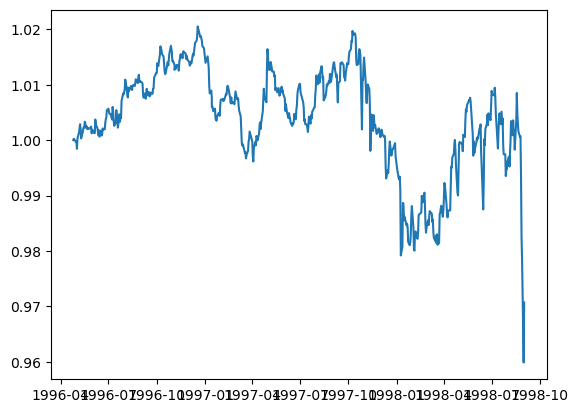

/Users/quintengeerts/Desktop/master thesis/stat_arb_thesis/empirical_analysis/Residual_Generator.py:117: RuntimeWarning: invalid value encountered in matmul
  psi  = np.linalg.inv(G.T @ C.T @ C @ G) @ G.T @ C.T
/Users/quintengeerts/Desktop/master thesis/stat_arb_thesis/empirical_analysis/Residual_Generator.py:118: RuntimeWarning: invalid value encountered in matmul
  beta = C @ G


AssertionError: 

In [27]:
# PARAMETERS
seed = 100  #np.random.randint(0,100000)

frames      = 6200
BUFFER_SIZE = 1000000
BATCH_SIZE  = 64
GAMMA       = 0.99
TAU         = 1e-2
eps_frames  = 500
min_eps     = 0.025
LR          = 1e-3
UPDATE_EVERY= 5
n_step      = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)

action_size       = 3
state_size        = [30]

agent = M_DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        layer_size=64,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed)

##########################

MINIMUM_BUFFER  = 5000      # minimum amount of experiences before the DRL agent starts learning
EPISODE_LENGTH  = 25        # episode length, only used for telling when to show the performance
WARMUP_TIME     = 0         # time needed to run the factor models before starting the strategy

LOOKBACK_WINDOW = 48        # lookback window for the IPCA residual generation (in months)
FACTORS         = 5         # the amount of factors used in the factor model
RETRAIN_PERIOD  = 252       # how often is the IPCA model retrained (in days)

RETRAIN_EVERY   = 250       # time before the feature extractor is retrained on new data
SIGNAL_WINDOW   = 30        # the length of the window used for extracting the signal

TRANS_COST      = 0.0       # transaction cost for changes in the portfolio
SHORT_COST      = 0.0       # cost of keeping a short position open

residual_generator = IPCA(monthly_panel=panel, 
                          permnos=price_df.columns.values.astype(int),
                          train_window=LOOKBACK_WINDOW,
                          n_factors = FACTORS,
                          retrain_period  = RETRAIN_PERIOD)

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=residual_generator,
                        episode_length=EPISODE_LENGTH,
                        lookback_window=LOOKBACK_WINDOW,
                        loading_window=LOADING_WINDOW,
                        signal_window=SIGNAL_WINDOW,
                        transaction_costs=TRANS_COST,
                        short_cost=SHORT_COST)

signal_extractor = FourierExtractor(signal_window=SIGNAL_WINDOW,
                                    add_alloc=False)

buffer           = ReplayBuffer(buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE,
                                device=device,
                                seed=seed,
                                gamma=GAMMA,
                                n_step=1)

state, _ = env.warm_up(warmup_time=WARMUP_TIME)
signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date])
features = state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray
features = signal_extractor.extract(features)

# INITIALISING SOME VARIABLES
score = 1
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

#training loop
for frame in range(1, frames+1):

    action = agent.act_para(features, eps)
    portfolio_allocations = np.vectorize(action_to_portfolio.get)(action) #actions need to be turned into allocations
    next_state, reward, done, info = env.step(portfolio_allocations.T)
    
    # ADD TO BUFFER 
    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], state[ticker].values, True)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], next_state[ticker].values, False)

        # DEEP REINFORCEMENT LEARNING UPDATE
        if len(buffer) > MINIMUM_BUFFER and idx % UPDATE_EVERY == 0:
            experiences = buffer.sample()
            # extract the features using the current feature extractor
            states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer = experiences
            features_buffer      = torch.FloatTensor(signal_extractor.extract(states_buffer))
            next_features_buffer = torch.FloatTensor(signal_extractor.extract(next_states_buffer))
            experiences          = (features_buffer, actions_buffer, rewards_buffer, next_features_buffer, dones_buffer)
            # perform a learning stepre
            agent.learn(experiences)

    # FEATURE EXTRACTOR RETRAINING
    if frame % RETRAIN_EVERY == 0:
        signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date]) 
    
    state     = next_state
    features  = next_state[env.tradeable_tickers].values.T
    features = signal_extractor.extract(features)

    score *= (env.p_l + 1)
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)
    
    if frame % EPISODE_LENGTH == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1 

In [29]:
price_df.columns

Index(['34817', '14338', '20482', '38914', '49154', '65541', '71686', '79879',
       '79881', '83976',
       ...
       '14323', '18420', '18421', '22517', '24563', '59379', '67571', '18428',
       '92157', '90110'],
      dtype='object', length=1179)

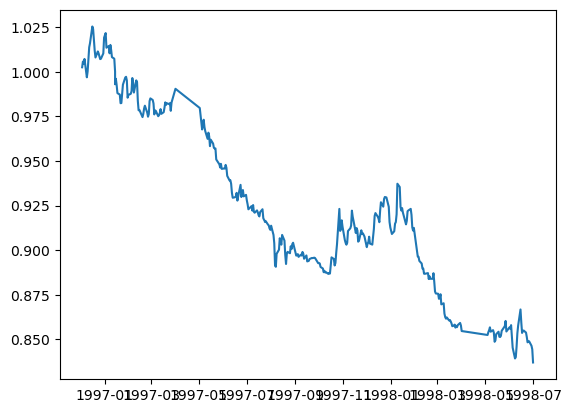

In [35]:
plt.plot((env.res_rets[['79881']].dropna()+1).cumprod())

### 6) Backwards test with fourier signal extractor -- QR-DQN

 Episode: 37 -- Annualized Return: 84.55% -- Annualized Volatility: 10.16% -- Annualized Sharpe: 8.32
 Episode: 37 -- Total ann. Return: 0.66% -- Total ann. Volatility: 4.87% -- Total ann. Sharpe: 0.13
Episode 38	Frame 950 	Average Score: 0.00

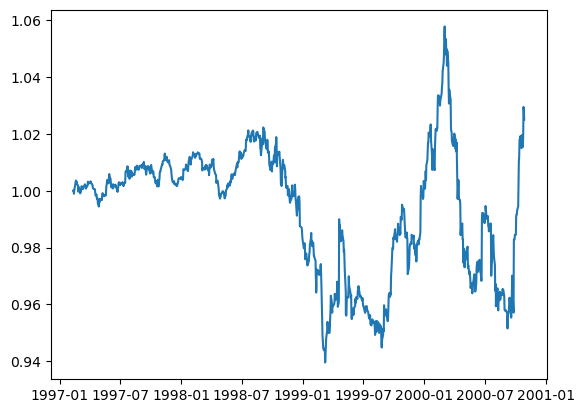

In [91]:
# PARAMETERS
seed = 100  #np.random.randint(0,100000)

frames      = 6200
BUFFER_SIZE = 1000000
BATCH_SIZE  = 64
GAMMA       = 0.99
TAU         = 1e-2
eps_frames  = 500
min_eps     = 0.001
LR          = 1e-3
UPDATE_EVERY= 5
n_step      = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)

action_size       = 3
state_size        = [30]

agent = DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        layer_size=256,
                        Network = 'DDQN',
                        n_step = 1,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed)

##########################

MINIMUM_BUFFER  = 5000      # minimum amount of experiences before the DRL agent starts learning
EPISODE_LENGTH  = 25        # episode length, only used for telling when to show the performance
LOOKBACK_WINDOW = 252       # lookback window used for the PCA estimation
LOADING_WINDOW  = 60        # last 30 values are used to create the loadings for the factor model
FACTORS         = 5         # the amount of factors used in the factor model
SIGNAL_WINDOW   = 30        # the length of the window used for extracting the signal
TRANS_COST      = 0.0    # transaction cost for changes in the portfolio
SHORT_COST      = 0.0    # cost of keeping a short position open
WARMUP_TIME     = 0         # time needed to run the factor models before starting the strategy
RETRAIN_EVERY   = 250       # time before the feature extractor is retrained on new data
USE_ALLOC       = False

residual_generator = PCA(price_data=price_df,
                         amount_of_factors = FACTORS,
                         loadings_window_size=LOADING_WINDOW,
                         lookback_window_size=LOOKBACK_WINDOW)

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=residual_generator,
                        episode_length=EPISODE_LENGTH,
                        lookback_window=LOOKBACK_WINDOW,
                        loading_window=LOADING_WINDOW,
                        signal_window=SIGNAL_WINDOW,
                        transaction_costs=TRANS_COST,
                        short_cost=SHORT_COST,
                        add_alloc=USE_ALLOC)

signal_extractor = FourierExtractor(signal_window=SIGNAL_WINDOW,
                                    add_alloc=USE_ALLOC)

buffer           = ReplayBuffer(buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE,
                                device=device,
                                seed=seed,
                                gamma=GAMMA,
                                n_step=1)

state, _ = env.warm_up(warmup_time=WARMUP_TIME)
signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date])
features = state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray
features = signal_extractor.extract(features)

# INITIALISING SOME VARIABLES
score = 1
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

#training loop
for frame in range(1, frames+1):

    action = agent.act_para(features, eps)
    portfolio_allocations = np.vectorize(action_to_portfolio.get)(action) #actions need to be turned into allocations
    next_state, reward, done, info = env.step(portfolio_allocations.T)
    
    # ADD TO BUFFER 
    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], state[ticker].values, True)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], next_state[ticker].values, False)

        # DEEP REINFORCEMENT LEARNING UPDATE
        if len(buffer) > MINIMUM_BUFFER and idx % UPDATE_EVERY == 0:
            experiences = buffer.sample()
            # extract the features using the current feature extractor
            states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer = experiences
            features_buffer      = torch.FloatTensor(signal_extractor.extract(states_buffer))
            next_features_buffer = torch.FloatTensor(signal_extractor.extract(next_states_buffer))
            experiences          = (features_buffer, actions_buffer, rewards_buffer, next_features_buffer, dones_buffer)
            # perform a learning stepre
            agent.learn(experiences)

    # FEATURE EXTRACTOR RETRAINING
    if frame % RETRAIN_EVERY == 0:
        signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date]) 
    
    state     = next_state
    features  = next_state[env.tradeable_tickers].values.T
    features = signal_extractor.extract(features)

    score *= (env.p_l + 1)
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)
    
    if frame % EPISODE_LENGTH == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1 